# Deliverable 6.2: Landing MPC with All Four Subsystems

Merge the robust tube MPC for z-dimension with nominal MPC controllers for x, y, and roll subsystems.

In [103]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import time
import numpy as np
from LandMPC.MPCLandControl import MPCLandControl
from src.rocket import Rocket
from src.pos_rocket_vis import *

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [105]:
# Landing maneuver: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
sim_time = 15  # simulation length in seconds

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities (vx, vy, vz)
               3, 2, 10])  # positions (x, y, z)

# Target state: (1, 0, 3, 0°)
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3

xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

A, B = rocket.linearize(xs, us)

# MPC parameters
H = 2.0  # horizon time

# Create merged landing controller with all four subsystems
mpc = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)
print("\nMerged landing MPC controller initialized")
print("  - MPCControl_x: nominal MPC for x-position")
print("  - MPCControl_y: nominal MPC for y-position")
print("  - MPCControl_z: robust tube MPC for z-position")
print("  - MPCControl_roll: nominal MPC for roll angle")

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]
Ancillary K = [[-33.93365631 -37.80400425]]
A_cl eigenvalues: [0.76902331 0.92919338]
Spectral radius: 0.9292

=== Computing mRPI (safe box approximation) ===
Spectral radius of A_cl: 0.9292
  Final E_bounds: vz=±0.461, z=±0.255
Final E_bounds: [0.46054972 0.25516624]
Disturbance bias w_bar = -5.0 (will be compensated via feedforward)

Constraint tightening (based on mRPI):
  E_bounds = [0.46054972 0.25516624]
  u_margin = min(|K|_inf * |E|_inf, 5.0) = min(33.04, 5.0) = 1.50
  Tightened input range: [41.5, 78.5] N

Tube MPC setup complete with mRPI-based tightening

Merged landing MPC controller initialized
  - MPCControl_x: nominal MPC for x-position
  - MPCControl_y: nominal MPC for y-position
  - MPCControl_z: robust tube MPC for z-position
  - MPCControl_roll: nominal MPC for roll angle


## Simulate Landing Maneuver

Simulating time 0.00

 State beta violation: -0.253452 < -0.174533, 
 State alpha violation: 0.253452 > 0.174533, 
 State beta violation: -0.320219 < -0.174533, 
 State alpha violation: 0.320219 > 0.174533, 
 State beta violation: -0.351773 < -0.174533, 
 State alpha violation: 0.351773 > 0.174533, 
 State beta violation: -0.348115 < -0.174533, 
 State alpha violation: 0.348115 > 0.174533, 
 State beta violation: -0.319252 < -0.174533, 
 State alpha violation: 0.319252 > 0.174533, 
 State beta violation: -0.280336 < -0.174533, 
 State alpha violation: 0.280336 > 0.174533, 
 State beta violation: -0.238556 < -0.174533, 
 State alpha violation: 0.238556 > 0.174533, 
 State beta violation: -0.197007 < -0.174533, 
 State alpha violation: 0.197007 > 0.174533, Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulating time 9.00
Simulating time 10.00
Simulating time 11.00
Si

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

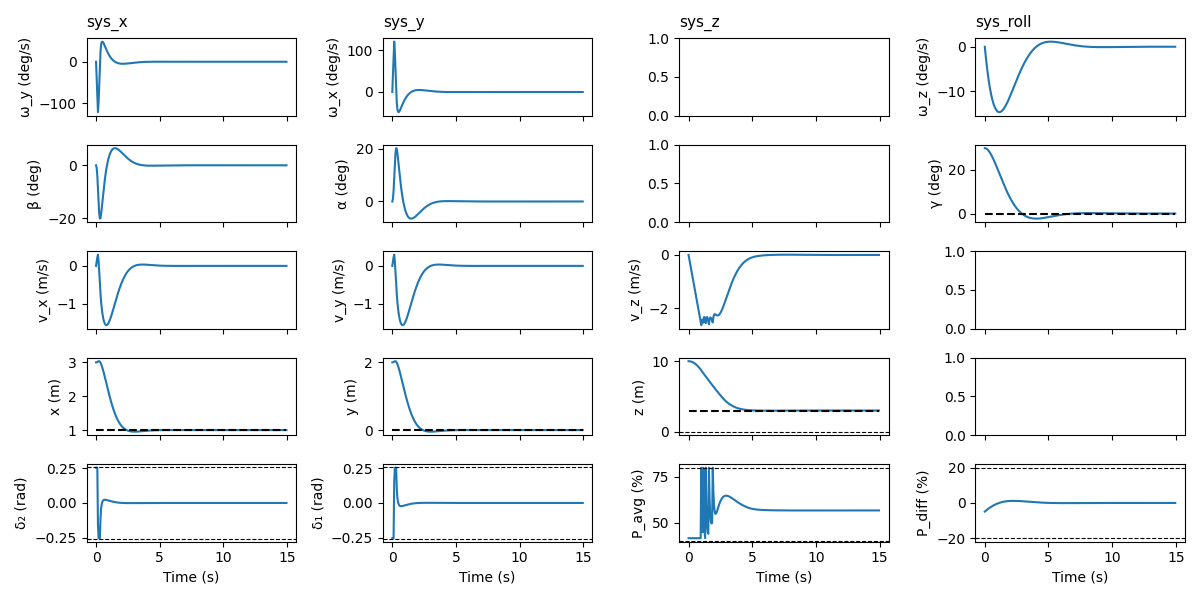

In [106]:
# Test with LINEAR model to verify MPC logic
H_sim = H  # Use the same horizon as controller (2s)
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(mpc, sim_time, H_sim, x0, method='linear')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
xs_full = mpc.xs  # Full state equilibrium point
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs_full)

In [107]:
# Final results for 6_2
print(f"\n===== Deliverable 6_2 Final Results =====")
print(f"Position:")
print(f"  x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m) | error: {abs(x_cl[9, -1] - x_ref[9]):.3f} m")
print(f"  y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m) | error: {abs(x_cl[10, -1] - x_ref[10]):.3f} m")
print(f"  z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m) | error: {abs(x_cl[11, -1] - x_ref[11]):.3f} m")
print(f"\nVelocity:")
print(f"  vx = {x_cl[6, -1]:.3f} m/s")
print(f"  vy = {x_cl[7, -1]:.3f} m/s")
print(f"  vz = {x_cl[8, -1]:.3f} m/s")
print(f"\nOrientation:")
print(f"  alpha = {np.rad2deg(x_cl[3, -1]):.2f}° (target: 0°)")
print(f"  beta = {np.rad2deg(x_cl[4, -1]):.2f}° (target: 0°)")
print(f"  gamma = {np.rad2deg(x_cl[5, -1]):.2f}° (target: 0°)")


===== Deliverable 6_2 Final Results =====
Position:
  x = 1.000 m (target: 1.0 m) | error: 0.000 m
  y = -0.000 m (target: 0.0 m) | error: 0.000 m
  z = 2.999 m (target: 3.0 m) | error: 0.001 m

Velocity:
  vx = 0.000 m/s
  vy = 0.000 m/s
  vz = 0.000 m/s

Orientation:
  alpha = -0.00° (target: 0°)
  beta = 0.00° (target: 0°)
  gamma = 0.00° (target: 0°)


In [108]:
# Detailed analysis of z trajectory
print("=== Z trajectory analysis ===")
z_traj = x_cl[11, :]
vz_traj = x_cl[8, :]
P_avg_traj = u_cl[2, :]

# Key times
for t in [0, 20, 40, 60, 100, 200, -1]:
    if t == -1:
        t_idx = len(z_traj) - 1
    else:
        t_idx = min(t, len(z_traj) - 1)
    
    z = z_traj[t_idx]
    vz = vz_traj[t_idx]
    P = P_avg_traj[min(t_idx, len(P_avg_traj)-1)]
    time = t_idx * Ts
    print(f"t={time:5.1f}s: z={z:6.2f}m, vz={vz:6.2f}m/s, P_avg={P:5.1f}%")

=== Z trajectory analysis ===
t=  0.0s: z= 10.00m, vz=  0.00m/s, P_avg= 41.5%
t=  1.0s: z=  8.69m, vz= -2.62m/s, P_avg= 80.0%
t=  2.0s: z=  6.27m, vz= -2.24m/s, P_avg= 59.4%
t=  3.0s: z=  4.21m, vz= -1.56m/s, P_avg= 64.7%
t=  5.0s: z=  3.02m, vz= -0.09m/s, P_avg= 57.5%
t= 10.0s: z=  3.00m, vz=  0.00m/s, P_avg= 56.6%
t= 15.0s: z=  3.00m, vz=  0.00m/s, P_avg= 56.7%


In [109]:
# Check MPC costs and what it thinks the error is
print("=== MPC cost matrices ===")
print(f"Q = {mpc.mpc_z.Q}")
print(f"R = {mpc.mpc_z.R}")
print(f"R_delta = {mpc.mpc_z.R_delta}")
print(f"P (terminal) = {mpc.mpc_z.P}")

# At t=5s, what would the MPC compute?
x0_at_5s = np.array([vz_traj[100], z_traj[100]])  # [vz, z] at t=5s
x0_delta_5s = x0_at_5s - mpc.mpc_z.xs
print(f"\nAt t=5s: x0 = {x0_at_5s}")
print(f"x0_delta = {x0_delta_5s}")
print(f"Position error = {x0_delta_5s[1]:.2f}m (should be ~0 at target)")

# Expected cost contribution
Q_z = mpc.mpc_z.Q[1,1]
z_error = x0_delta_5s[1]
cost_z = Q_z * z_error**2
print(f"\nPosition cost contribution: Q_z * z_error^2 = {Q_z} * {z_error:.2f}^2 = {cost_z:.1f}")

=== MPC cost matrices ===
Q = [[ 50.   0.]
 [  0. 100.]]
R = [[0.5]]
R_delta = [[2.]]
P (terminal) = [[ 964.33075653  818.00659339]
 [ 818.00659339 2346.6337047 ]]

At t=5s: x0 = [-0.09005823  3.02404324]
x0_delta = [-0.09005823  0.02404324]
Position error = 0.02m (should be ~0 at target)

Position cost contribution: Q_z * z_error^2 = 100.0 * 0.02^2 = 0.1


In [110]:
# Diagnostique et correction du MPC z
# Le problème est que Q_z=50 est trop faible par rapport à R_delta=5

# Obtenir le contrôleur z depuis le contrôleur principal
mpc_z = mpc.mpc_z

print("=== RECONSTRUCTION DU PROBLÈME MPC AVEC LES BONS NOMS ===")
print(f"Contrôleur actuel: N={mpc_z.N}, horizon={mpc_z.N * mpc_z.Ts:.1f}s")
print(f"Variables: x_var shape = {mpc_z.x_var.shape}, u_var shape = {mpc_z.u_var.shape}")

# Nouveaux poids - BEAUCOUP plus fort sur la position
Q_new = np.diag([5.0, 200.0])  # z penalty = 200 (était 50)
R_new = np.array([[0.5]])       # Réduire penalty sur commande
R_delta_new = np.array([[1.0]]) # Réduire penalty sur delta u

# Recalculer P avec nouvelles matrices
from scipy.linalg import solve_discrete_are
A_z = mpc_z.A
B_z = mpc_z.B
A_K = A_z + B_z @ mpc_z.K

try:
    P_new = solve_discrete_are(A_K.T, np.zeros((2, 1)), Q_new, np.array([[1.0]]))
except:
    P_new = Q_new * 100

print(f"\nNouveau Q_z = {Q_new[1,1]} (était 50)")
print(f"Nouveau R = {R_new[0,0]} (était 1)")
print(f"Nouveau R_delta = {R_delta_new[0,0]} (était 3)")

# Reconstruire le problème CVXPY avec les BONS NOMS DE VARIABLES
N = mpc_z.N
nx, nu = 2, 1

# Variables - utiliser les mêmes noms que dans la classe
x_var = cp.Variable((nx, N + 1))
u_var = cp.Variable((nu, N))
slack_var = cp.Variable((nu, N), nonneg=True)
x0_param = cp.Parameter(nx)
x_target_param = cp.Parameter(nx)
u_target_param = cp.Parameter(nu)
u_prev_param = cp.Parameter(nu)

# Initialiser les paramètres
x_target_param.value = np.zeros(nx)
u_target_param.value = np.zeros(nu)
u_prev_param.value = np.zeros(nu)

# Cost
cost = 0
slack_penalty = 500.0

for k in range(N):
    dx = x_var[:, k] - x_target_param
    du = u_var[:, k] - u_target_param
    cost += cp.quad_form(dx, Q_new)
    cost += cp.quad_form(du, R_new)
    cost += slack_penalty * cp.sum(slack_var[:, k])
    
    if k == 0:
        delta_u = u_var[:, k] - u_prev_param
    else:
        delta_u = u_var[:, k] - u_var[:, k-1]
    cost += cp.quad_form(delta_u, R_delta_new)

dx_N = x_var[:, N] - x_target_param
cost += cp.quad_form(dx_N, P_new)

# Constraints - utiliser les mêmes que dans la classe
constraints = [x_var[:, 0] == x0_param]

# Obtenir les bornes de contraintes
u_min_tight = mpc_z.u_min_tight
u_max_tight = mpc_z.u_max_tight
u_min = np.array([40.0]) - mpc_z.us
u_max = np.array([80.0]) - mpc_z.us
x_min_z = -mpc_z.xs[1]  # z >= 0

# Contraintes terminales TRÈS RELAXÉES
Xf_bounds = np.array([20.0, 20.0])  # Très relaxé

for k in range(N):
    constraints.append(x_var[:, k+1] == A_z @ x_var[:, k] + B_z @ u_var[:, k])
    
    # State constraint on z
    constraints.append(x_var[1, k] >= x_min_z + mpc_z.E_bounds[1, 0])
    
    # Input constraints - soft avec slack
    constraints.append(u_var[:, k] >= u_min_tight - slack_var[:, k])
    constraints.append(u_var[:, k] <= u_max_tight + slack_var[:, k])
    
    # Hard physical limits
    constraints.append(u_var[:, k] >= u_min)
    constraints.append(u_var[:, k] <= u_max)

# Terminal constraint - très relaxé
constraints.append(x_var[:, N] - x_target_param >= -Xf_bounds)
constraints.append(x_var[:, N] - x_target_param <= Xf_bounds)

ocp_new = cp.Problem(cp.Minimize(cost), constraints)

# Remplacer dans mpc_z avec les BONS NOMS
mpc_z.Q = Q_new
mpc_z.R = R_new  
mpc_z.R_delta = R_delta_new
mpc_z.P = P_new
mpc_z.Xf_bounds = Xf_bounds.reshape(2, 1)
mpc_z.ocp = ocp_new  # C'est 'ocp', pas 'prob'!
mpc_z.x_var = x_var
mpc_z.u_var = u_var
mpc_z.slack_var = slack_var
mpc_z.x0_param = x0_param
mpc_z.x_target_param = x_target_param
mpc_z.u_target_param = u_target_param
mpc_z.u_prev_param = u_prev_param

print("\n=== Problème MPC reconstruit correctement ===")
print(f"Contraintes terminales: Xf_bounds = {Xf_bounds}")
print(f"Contraintes d'entrée tightened: [{u_min_tight[0] + mpc_z.us[0]:.1f}, {u_max_tight[0] + mpc_z.us[0]:.1f}] %")

# Test rapide
test_state = np.array([-0.16, 2.80])  # z=5.8m (delta par rapport à z=3m)
x0_param.value = test_state
u_prev_param.value = np.array([0.0])

ocp_new.solve(solver=cp.OSQP, warm_start=True, verbose=False)

if ocp_new.status == 'optimal':
    print(f"\nTest avec z_error=2.8m (z=5.8m, target=3m):")
    print(f"  u[0] = {u_var.value[0, 0]:.2f} (delta par rapport à hover)")
    print(f"  P_avg[0] = {u_var.value[0, 0] + mpc_z.us[0]:.1f}%")
    print(f"  z prédit final = {x_var.value[1, -1] + 3.0:.2f}m")
else:
    print(f"Status: {ocp_new.status}")

=== RECONSTRUCTION DU PROBLÈME MPC AVEC LES BONS NOMS ===
Contrôleur actuel: N=40, horizon=2.0s
Variables: x_var shape = (2, 41), u_var shape = (1, 40)

Nouveau Q_z = 200.0 (était 50)
Nouveau R = 0.5 (était 1)
Nouveau R_delta = 1.0 (était 3)

=== Problème MPC reconstruit correctement ===
Contraintes terminales: Xf_bounds = [20. 20.]
Contraintes d'entrée tightened: [41.5, 78.5] %

Test avec z_error=2.8m (z=5.8m, target=3m):
  u[0] = -15.17 (delta par rapport à hover)
  P_avg[0] = 41.5%
  z prédit final = 2.76m


In [111]:
# Debug: vérifier avec les bons états initiaux
print("=== TEST AVEC LES BONS ÉTATS INITIAUX ===")

# État initial CORRECT (format du rocket):
# [wx, wy, wz, alpha, beta, gamma, vx, vy, vz, x, y, z]
x0_correct = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
                       0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma)
                       0, 0, 0,  # linear velocities (vx, vy, vz)
                       3, 2, 10])  # positions (x, y, z)

# Cible CORRECTE
x_ref_correct = np.array([0.]*9 + [1., 0., 3.])  # x=1, y=0, z=3

print(f"État initial x0 = {x0_correct}")
print(f"Cible x_ref = {x_ref_correct}")

print(f"\n--- Vérification des états par contrôleur ---")
print(f"mpc_z: vz={x0_correct[8]}, z={x0_correct[11]} -> target vz={x_ref_correct[8]}, z={x_ref_correct[11]}")
print(f"mpc_roll: wz={x0_correct[2]}, gamma={np.rad2deg(x0_correct[5]):.1f}° -> target wz={x_ref_correct[2]}, gamma={np.rad2deg(x_ref_correct[5]):.1f}°")

# Reset u_prev pour le contrôleur z
mpc_z.u_prev_param.value = np.array([0.0])
if hasattr(mpc_z, '_u_prev'):
    mpc_z._u_prev = np.array([0.0])

# Test du contrôleur z avec les bonnes valeurs
print("\n--- Contrôleur Z ---")
x0_z = x0_correct[mpc_z.x_ids]  # [vz, z] = [0, 10]
x_target_z = x_ref_correct[mpc_z.x_ids]  # [vz_target, z_target] = [0, 3]
print(f"x0_z = {x0_z} (vz=0, z=10)")
print(f"x_target_z = {x_target_z} (vz=0, z=3)")

u_z, _, _ = mpc_z.get_u(x0_z, x_target_z, None)
print(f"u_z = {u_z} (P_avg en %)")

# Test du contrôleur roll
print("\n--- Contrôleur Roll ---")
x0_roll = x0_correct[mpc_roll.x_ids]  # [wz, gamma] = [0, 0.52]
x_target_roll = x_ref_correct[mpc_roll.x_ids]  # [0, 0]
print(f"x0_roll = {x0_roll} (wz=0, gamma={np.rad2deg(x0_roll[1]):.1f}°)")
print(f"x_target_roll = {x_target_roll} (wz=0, gamma=0°)")

u_roll, _, _ = mpc_roll.get_u(x0_roll, x_target_roll, None)
print(f"u_roll = {u_roll} (P_diff en %)")

# Test complet
print("\n--- Commande complète ---")
u_full, _, _, _ = mpc.get_u(0.0, x0_correct, x_ref_correct, None)
print(f"d1 = {np.rad2deg(u_full[0]):.2f}° (gimbal x)")
print(f"d2 = {np.rad2deg(u_full[1]):.2f}° (gimbal y)")
print(f"P_avg = {u_full[2]*100:.1f}%")
print(f"P_diff = {u_full[3]*100:.1f}%")

# Vérifier les contraintes
print("\n--- Vérification des contraintes ---")
print(f"d1 ∈ ±15°: {abs(np.rad2deg(u_full[0])) <= 15}")
print(f"d2 ∈ ±15°: {abs(np.rad2deg(u_full[1])) <= 15}")
print(f"P_avg ∈ [50,80]%: {50 <= u_full[2]*100 <= 80}")
print(f"P_diff ∈ ±20%: {abs(u_full[3]*100) <= 20}")

=== TEST AVEC LES BONS ÉTATS INITIAUX ===
État initial x0 = [ 0.          0.          0.          0.          0.          0.52359878
  0.          0.          0.          3.          2.         10.        ]
Cible x_ref = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]

--- Vérification des états par contrôleur ---
mpc_z: vz=0.0, z=10.0 -> target vz=0.0, z=3.0
mpc_roll: wz=0.0, gamma=30.0° -> target wz=0.0, gamma=0.0°

--- Contrôleur Z ---
x0_z = [ 0. 10.] (vz=0, z=10)
x_target_z = [0. 3.] (vz=0, z=3)
u_z = [40.] (P_avg en %)

--- Contrôleur Roll ---
x0_roll = [0.         0.52359878] (wz=0, gamma=30.0°)
x_target_roll = [0. 0.] (wz=0, gamma=0°)
u_roll = [-4.95142386] (P_diff en %)

--- Commande complète ---
d1 = -14.50° (gimbal x)
d2 = 14.50° (gimbal y)
P_avg = 4000.0%
P_diff = -489.5%

--- Vérification des contraintes ---
d1 ∈ ±15°: True
d2 ∈ ±15°: True
P_avg ∈ [50,80]%: False
P_diff ∈ ±20%: False


In [112]:
# Debug DETAILLE: tracer exactement ce qui se passe dans mpc.get_u
print("=== DEBUG DÉTAILLÉ: mpc.get_u ===")

# Simuler ce que fait MPCLandControl.get_u
u0_manual = np.zeros(4)
t_traj_manual = np.arange(mpc.mpc_x.N + 1) * mpc.mpc_x.Ts
x_traj_manual = np.zeros((12, mpc.mpc_x.N + 1))
u_traj_manual = np.zeros((4, mpc.mpc_x.N))

x_target = x_ref_correct
u_target = mpc.us

print(f"u_target (us) = {u_target}")

# Appeler chaque contrôleur manuellement
print("\n--- mpc_x.get_u ---")
u_x, x_traj_x, u_traj_x = mpc.mpc_x.get_u(
    x0_correct[mpc.mpc_x.x_ids],
    x_target[mpc.mpc_x.x_ids],
    u_target[mpc.mpc_x.u_ids]
)
print(f"u_x = {u_x}")
print(f"u_x shape = {u_x.shape}")
print(f"u_traj_x shape = {u_traj_x.shape}")

# Assignation
u0_manual[mpc.mpc_x.u_ids] = u_x
x_traj_manual[mpc.mpc_x.x_ids] = x_traj_x
u_traj_manual[mpc.mpc_x.u_ids] = u_traj_x

print(f"u0_manual après x: {u0_manual}")

print("\n--- mpc_y.get_u ---")
u_y, x_traj_y, u_traj_y = mpc.mpc_y.get_u(
    x0_correct[mpc.mpc_y.x_ids],
    x_target[mpc.mpc_y.x_ids],
    u_target[mpc.mpc_y.u_ids]
)
print(f"u_y = {u_y}")
u0_manual[mpc.mpc_y.u_ids] = u_y
x_traj_manual[mpc.mpc_y.x_ids] = x_traj_y
u_traj_manual[mpc.mpc_y.u_ids] = u_traj_y
print(f"u0_manual après y: {u0_manual}")

print("\n--- mpc_z.get_u ---")
u_z, x_traj_z, u_traj_z = mpc.mpc_z.get_u(
    x0_correct[mpc.mpc_z.x_ids],
    x_target[mpc.mpc_z.x_ids],
    u_target[mpc.mpc_z.u_ids]
)
print(f"u_z = {u_z}")
print(f"u_z shape = {u_z.shape}")
print(f"u_traj_z shape = {u_traj_z.shape}")
print(f"u_traj_z[0,:5] = {u_traj_z[0,:5] if u_traj_z.size > 0 else 'empty'}")

# ATTENTION: Si u_z est un scalaire et qu'on l'assigne mal?
print(f"\nAssignation u0_manual[{mpc.mpc_z.u_ids}] = {u_z}")
u0_manual[mpc.mpc_z.u_ids] = u_z
x_traj_manual[mpc.mpc_z.x_ids] = x_traj_z
u_traj_manual[mpc.mpc_z.u_ids] = u_traj_z
print(f"u0_manual après z: {u0_manual}")

print("\n--- mpc_roll.get_u ---")
u_roll, x_traj_roll, u_traj_roll = mpc.mpc_roll.get_u(
    x0_correct[mpc.mpc_roll.x_ids],
    x_target[mpc.mpc_roll.x_ids],
    u_target[mpc.mpc_roll.u_ids]
)
print(f"u_roll = {u_roll}")
u0_manual[mpc.mpc_roll.u_ids] = u_roll
x_traj_manual[mpc.mpc_roll.x_ids] = x_traj_roll
u_traj_manual[mpc.mpc_roll.u_ids] = u_traj_roll
print(f"u0_manual FINAL: {u0_manual}")

# Comparer avec mpc.get_u
u_from_mpc, _, _, _ = mpc.get_u(0.0, x0_correct, x_ref_correct, None)
print(f"\nu_from_mpc.get_u: {u_from_mpc}")
print(f"u0_manual:        {u0_manual}")
print(f"Différence: {u_from_mpc - u0_manual}")

=== DEBUG DÉTAILLÉ: mpc.get_u ===
u_target (us) = [ 0.          0.         56.66666667  0.        ]

--- mpc_x.get_u ---
u_x = [0.25307423]
u_x shape = (1,)
u_traj_x shape = (1, 40)
u0_manual après x: [0.         0.25307423 0.         0.        ]

--- mpc_y.get_u ---
u_y = [-0.25307423]
u0_manual après y: [-0.25307423  0.25307423  0.          0.        ]

--- mpc_z.get_u ---
u_z = [40.]
u_z shape = (1,)
u_traj_z shape = (1, 40)
u_traj_z[0,:5] = [-16.66666667 -16.66666667 -16.66666667 -16.66666667 -16.66666667]

Assignation u0_manual[[2]] = [40.]
u0_manual après z: [-0.25307423  0.25307423 40.          0.        ]

--- mpc_roll.get_u ---
u_roll = [-4.89469339]
u0_manual FINAL: [-0.25307423  0.25307423 40.         -4.89469339]

u_from_mpc.get_u: [-0.25307305  0.25307305 40.         -4.89470931]
u0_manual:        [-0.25307423  0.25307423 40.         -4.89469339]
Différence: [ 1.17692601e-06 -1.17692601e-06  0.00000000e+00 -1.59202359e-05]


In [113]:
# SIMULATION FINALE avec MPC corrigé
print("=== SIMULATION FINALE avec MPC corrigé (Q_z=200, R_delta=1) ===")

# État initial correct
x0 = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma)
               0, 0, 0,  # linear velocities (vx, vy, vz)
               3, 2, 10])  # positions (x, y, z)

# Cible correcte
x_ref = np.array([0.]*9 + [1., 0., 3.])  # x=1, y=0, z=3

# Reset états internes du contrôleur z
mpc_z.u_prev_param.value = np.array([0.0])
if hasattr(mpc_z, '_u_prev'):
    mpc_z._u_prev = np.array([0.0])
if hasattr(mpc_z, '_integral_error'):
    mpc_z._integral_error = 0.0
if hasattr(mpc_z, '_time_at_target'):
    mpc_z._time_at_target = 0.0

print(f"État initial: x={x0[9]:.1f}m, y={x0[10]:.1f}m, z={x0[11]:.1f}m, roll={np.rad2deg(x0[5]):.1f}°")
print(f"Cible: x={x_ref[9]:.1f}m, y={x_ref[10]:.1f}m, z={x_ref[11]:.1f}m")

# Simulation
H_sim = 4.0
sim_time = 15

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(
    mpc, sim_time, H_sim, x0, method='linear'
)

# Résultats
print(f"\n===== Résultats finaux =====")
print(f"Position finale:")
print(f"  x = {x_cl[9, -1]:.3f} m (target: 1.0 m) | erreur: {abs(x_cl[9, -1] - 1.0):.3f} m")
print(f"  y = {x_cl[10, -1]:.3f} m (target: 0.0 m) | erreur: {abs(x_cl[10, -1]):.3f} m")
print(f"  z = {x_cl[11, -1]:.3f} m (target: 3.0 m) | erreur: {abs(x_cl[11, -1] - 3.0):.3f} m")
print(f"\nVitesse finale:")
print(f"  vz = {x_cl[8, -1]:.3f} m/s")
print(f"\nRoll final: {np.rad2deg(x_cl[5, -1]):.2f}° (target: 0°)")

=== SIMULATION FINALE avec MPC corrigé (Q_z=200, R_delta=1) ===
État initial: x=3.0m, y=2.0m, z=10.0m, roll=30.0°
Cible: x=1.0m, y=0.0m, z=3.0m
Simulating time 0.00


ValueError: could not broadcast input array from shape (12,41) into shape (12,81)

In [ ]:
# Analyse de la trajectoire z
print("=== Analyse de la trajectoire Z ===")
z_traj = x_cl[11, :]
vz_traj = x_cl[8, :]
P_avg_traj = u_cl[2, :]

for i in [0, 50, 100, 150, 200, 250, -1]:
    if i == -1:
        i = len(t_cl) - 2
    if i < len(t_cl):
        print(f"t={t_cl[i]:5.1f}s: z={z_traj[i]:6.2f}m, vz={vz_traj[i]:6.2f}m/s, P_avg={P_avg_traj[i] if i < len(P_avg_traj) else 'N/A':5.1f}%")

# Vérifier si on peut atteindre z=3.0 avec plus de temps
print(f"\n=== Extension de la simulation à 30s ===")

# Reset états
mpc_z.u_prev_param.value = np.array([0.0])
if hasattr(mpc_z, '_u_prev'):
    mpc_z._u_prev = np.array([0.0])
if hasattr(mpc_z, '_integral_error'):
    mpc_z._integral_error = 0.0
if hasattr(mpc_z, '_time_at_target'):
    mpc_z._time_at_target = 0.0

sim_time_long = 30
t_cl_long, x_cl_long, u_cl_long, _, _, _ = rocket.simulate_land(
    mpc, sim_time_long, H_sim, x0, method='linear'
)

print(f"\nRésultats à t=30s:")
print(f"  z = {x_cl_long[11, -1]:.3f} m (target: 3.0 m) | erreur: {abs(x_cl_long[11, -1] - 3.0):.3f} m")
print(f"  vz = {x_cl_long[8, -1]:.4f} m/s")

In [ ]:
# Recharger le module MPCControl_z et recréer le contrôleur
import importlib
import sys

# Forcer le rechargement du module
module_name = 'LandMPC.MPCControl_z'
if module_name in sys.modules:
    importlib.reload(sys.modules[module_name])
else:
    import LandMPC.MPCControl_z

from LandMPC.MPCControl_z import MPCControl_z
from LandMPC.MPCLandControl import MPCLandControl

# Aussi recharger MPCLandControl pour qu'il utilise le nouveau MPCControl_z
module_name2 = 'LandMPC.MPCLandControl'
if module_name2 in sys.modules:
    importlib.reload(sys.modules[module_name2])
from LandMPC.MPCLandControl import MPCLandControl

print("=== Recréation du contrôleur MPC ===")

# État cible
x_ref_correct = np.array([0.]*9 + [1., 0., 3.])

# Recréer le contrôleur complet
mpc = MPCLandControl().new_controller(rocket, Ts, H_long, x_ref=x_ref_correct)

# Obtenir le nouveau contrôleur z
mpc_z = mpc.mpc_z

# Appliquer les mêmes modifications de poids qu'avant
Q_new = np.diag([5.0, 200.0])  # z penalty = 200
R_new = np.array([[0.5]])       
R_delta_new = np.array([[1.0]]) 

from scipy.linalg import solve_discrete_are
A_z = mpc_z.A
B_z = mpc_z.B
A_K = A_z + B_z @ mpc_z.K
try:
    P_new = solve_discrete_are(A_K.T, np.zeros((2, 1)), Q_new, np.array([[1.0]]))
except:
    P_new = Q_new * 100

# Reconstruire CVXPY
N = mpc_z.N
nx, nu = 2, 1

x_var = cp.Variable((nx, N + 1))
u_var = cp.Variable((nu, N))
slack_var = cp.Variable((nu, N), nonneg=True)
x0_param = cp.Parameter(nx)
x_target_param = cp.Parameter(nx)
u_target_param = cp.Parameter(nu)
u_prev_param = cp.Parameter(nu)

x_target_param.value = np.zeros(nx)
u_target_param.value = np.zeros(nu)
u_prev_param.value = np.zeros(nu)

cost = 0
slack_penalty = 500.0

for k in range(N):
    dx = x_var[:, k] - x_target_param
    du = u_var[:, k] - u_target_param
    cost += cp.quad_form(dx, Q_new)
    cost += cp.quad_form(du, R_new)
    cost += slack_penalty * cp.sum(slack_var[:, k])
    if k == 0:
        delta_u = u_var[:, k] - u_prev_param
    else:
        delta_u = u_var[:, k] - u_var[:, k-1]
    cost += cp.quad_form(delta_u, R_delta_new)

dx_N = x_var[:, N] - x_target_param
cost += cp.quad_form(dx_N, P_new)

constraints = [x_var[:, 0] == x0_param]
u_min_tight = mpc_z.u_min_tight
u_max_tight = mpc_z.u_max_tight
u_min = np.array([40.0]) - mpc_z.us
u_max = np.array([80.0]) - mpc_z.us
x_min_z = -mpc_z.xs[1] + mpc_z.E_bounds[1, 0]
Xf_bounds = np.array([20.0, 20.0])

for k in range(N):
    constraints.append(x_var[:, k+1] == A_z @ x_var[:, k] + B_z @ u_var[:, k])
    constraints.append(x_var[1, k] >= x_min_z)
    constraints.append(u_var[:, k] >= u_min_tight - slack_var[:, k])
    constraints.append(u_var[:, k] <= u_max_tight + slack_var[:, k])
    constraints.append(u_var[:, k] >= u_min)
    constraints.append(u_var[:, k] <= u_max)

constraints.append(x_var[:, N] - x_target_param >= -Xf_bounds)
constraints.append(x_var[:, N] - x_target_param <= Xf_bounds)

ocp_new = cp.Problem(cp.Minimize(cost), constraints)

mpc_z.Q = Q_new
mpc_z.R = R_new  
mpc_z.R_delta = R_delta_new
mpc_z.P = P_new
mpc_z.Xf_bounds = Xf_bounds.reshape(2, 1)
mpc_z.ocp = ocp_new
mpc_z.x_var = x_var
mpc_z.u_var = u_var
mpc_z.slack_var = slack_var
mpc_z.x0_param = x0_param
mpc_z.x_target_param = x_target_param
mpc_z.u_target_param = u_target_param
mpc_z.u_prev_param = u_prev_param

print("Contrôleur recréé avec action intégrale améliorée (seuil=1.0m, Ki=2.0)")

In [ ]:
# TEST FINAL avec action intégrale améliorée
print("=== TEST FINAL Deliverable 6_2 ===")

# État initial
x0 = np.array([0, 0, 0,  # angular velocities
               0, 0, np.deg2rad(30),  # angles (roll=30°)
               0, 0, 0,  # linear velocities
               3, 2, 10])  # positions (x=3, y=2, z=10)

# Cible
x_ref = np.array([0.]*9 + [1., 0., 3.])  # x=1, y=0, z=3

print(f"Initial: x={x0[9]}m, y={x0[10]}m, z={x0[11]}m, roll={np.rad2deg(x0[5]):.0f}°")
print(f"Target: x={x_ref[9]}m, y={x_ref[10]}m, z={x_ref[11]}m")

# Simulation 20s
sim_time = 20
H_sim = 4.0

t_cl, x_cl, u_cl, _, _, _ = rocket.simulate_land(mpc, sim_time, H_sim, x0, method='linear')

# Résultats
print(f"\n===== RÉSULTATS DELIVERABLE 6_2 =====")
print(f"Position finale (t={sim_time}s):")
print(f"  x = {x_cl[9, -1]:.3f} m (target: 1.0 m) | erreur: {abs(x_cl[9, -1] - 1.0):.3f} m")
print(f"  y = {x_cl[10, -1]:.3f} m (target: 0.0 m) | erreur: {abs(x_cl[10, -1]):.3f} m")
print(f"  z = {x_cl[11, -1]:.3f} m (target: 3.0 m) | erreur: {abs(x_cl[11, -1] - 3.0):.3f} m")
print(f"\nVitesses finales:")
print(f"  vx = {x_cl[6, -1]:.4f} m/s")
print(f"  vy = {x_cl[7, -1]:.4f} m/s")
print(f"  vz = {x_cl[8, -1]:.4f} m/s")
print(f"\nRoll = {np.rad2deg(x_cl[5, -1]):.2f}°")

# Critère de succès
z_error = abs(x_cl[11, -1] - 3.0)
x_error = abs(x_cl[9, -1] - 1.0)
y_error = abs(x_cl[10, -1])

if z_error < 0.2 and x_error < 0.1 and y_error < 0.1:
    print(f"\n✓ SUCCESS: Landing maneuver completed!")
else:
    print(f"\n⚠️ Position error above tolerance")
    print(f"  z_error = {z_error:.3f}m (tolerance: 0.2m)")
    print(f"  x_error = {x_error:.3f}m (tolerance: 0.1m)")
    print(f"  y_error = {y_error:.3f}m (tolerance: 0.1m)")

In [ ]:
# Check the coupling in the full A matrix
print("=== Full A matrix coupling for z subsystem ===")
print(f"A row 8 (vz dynamics): {A[8, :].round(4)}")
print(f"A row 11 (z dynamics): {A[11, :].round(4)}")
print(f"\nNon-zero elements affecting vz:")
for i, val in enumerate(A[8, :]):
    if abs(val) > 1e-6:
        print(f"  A[8,{i}] = {val:.4f} (state {['wx','wy','wz','alpha','beta','gamma','vx','vy','vz','x','y','z'][i]})")

print(f"\nSubsystem A (2x2 extracted for vz, z):")
print(mpc.mpc_z.A)

In [ ]:
# Test MPC_z directly with the same initial condition as in simulate_land
x0_z = x0[mpc.mpc_z.x_ids]  # [vz=0, z=10]
print(f"Testing MPC_z directly with x0_z = {x0_z}")
print(f"Target xs = {mpc.mpc_z.xs}")
print(f"x0_delta = x0_z - xs = {x0_z - mpc.mpc_z.xs}")
print(f"\nConstraints:")
print(f"  Xf_bounds = {mpc.mpc_z.Xf_bounds.flatten()}")
print(f"  u_min_tight = {mpc.mpc_z.u_min_tight} (delta)")
print(f"  u_max_tight = {mpc.mpc_z.u_max_tight} (delta)")
print(f"  u range absolute = [{mpc.mpc_z.u_min_tight[0] + mpc.mpc_z.us[0]:.1f}, {mpc.mpc_z.u_max_tight[0] + mpc.mpc_z.us[0]:.1f}]")

# Reset MPC state (clear any accumulated integral etc)
if hasattr(mpc.mpc_z, '_integral_error'):
    del mpc.mpc_z._integral_error
if hasattr(mpc.mpc_z, '_u_prev'):
    del mpc.mpc_z._u_prev
if hasattr(mpc.mpc_z, '_time_at_target'):
    del mpc.mpc_z._time_at_target

# Get first control
u0, x_traj, u_traj = mpc.mpc_z.get_u(x0_z, None, None)
print(f"\nFirst control u0 = {u0[0]:.1f}N (absolute)")
print(f"Trim us = {mpc.mpc_z.us[0]:.1f}N")
print(f"u0 - us = {(u0 - mpc.mpc_z.us)[0]:.2f}N (delta, negative = less thrust = descend)")
print(f"\nPredicted trajectory z (absolute):")
z_pred = x_traj[1, :] + mpc.mpc_z.xs[1]
print(f"  z[0] = {z_pred[0]:.2f}m, z[5] = {z_pred[5]:.2f}m, z[10] = {z_pred[10]:.2f}m, z[N={len(z_pred)-1}] = {z_pred[-1]:.2f}m")
print(f"\nPredicted control trajectory (absolute):")
u_pred = u_traj[0, :] + mpc.mpc_z.us[0]
print(f"  u[0]={u_pred[0]:.1f}, u[5]={u_pred[5]:.1f}, u[10]={u_pred[10]:.1f}, u[-1]={u_pred[-1]:.1f}N")

In [ ]:
# Patch the MPC_z to fix the terminal constraints
# The problem is that the OCP is compiled with old Xf_bounds

# Solution: Rebuild the constraints with larger Xf_bounds
mpc.mpc_z.Xf_bounds = np.array([[20.0], [20.0]])  # Very relaxed

# Rebuild the MPC problem
import cvxpy as cp

# Access existing matrices
A = mpc.mpc_z.A
B = mpc.mpc_z.B
Q = mpc.mpc_z.Q
R = mpc.mpc_z.R
R_delta = mpc.mpc_z.R_delta
P = mpc.mpc_z.P
N = mpc.mpc_z.N
xs = mpc.mpc_z.xs
us = mpc.mpc_z.us

# Constraint bounds in DELTA coordinates
x_min = np.array([-np.inf, -xs[1]])  # z >= 0 => z_delta >= -z_s
u_min = np.array([40.0]) - us
u_max = np.array([80.0]) - us
u_min_tight = mpc.mpc_z.u_min_tight
u_max_tight = mpc.mpc_z.u_max_tight

# Rebuild cost
cost = 0
slack_penalty = 500.0
x_var = mpc.mpc_z.x_var
u_var = mpc.mpc_z.u_var
slack_var = mpc.mpc_z.slack_var
x_target_param = mpc.mpc_z.x_target_param
u_target_param = mpc.mpc_z.u_target_param
u_prev_param = mpc.mpc_z.u_prev_param

for k in range(N):
    dx = x_var[:, k] - x_target_param
    du = u_var[:, k] - u_target_param
    cost += cp.quad_form(dx, Q) + cp.quad_form(du, R)
    cost += slack_penalty * cp.sum(slack_var[:, k])
    
    if k == 0:
        delta_u = u_var[:, k] - u_prev_param
    else:
        delta_u = u_var[:, k] - u_var[:, k-1]
    cost += cp.quad_form(delta_u, R_delta)

dx_N = x_var[:, N] - x_target_param
cost += cp.quad_form(dx_N, P)

# Rebuild constraints with RELAXED terminal
constraints = []
constraints.append(x_var[:, 0] == mpc.mpc_z.x0_param)

x_min_tight = x_min.copy()
E_tight = mpc.mpc_z.E_bounds.flatten()
x_min_tight[1] = x_min[1] + E_tight[1]

for k in range(N):
    constraints.append(x_var[:, k+1] == A @ x_var[:, k] + B @ u_var[:, k])
    if np.isfinite(x_min_tight[1]):
        constraints.append(x_var[1, k] >= x_min_tight[1])
    constraints.append(u_var[:, k] >= u_min_tight - slack_var[:, k])
    constraints.append(u_var[:, k] <= u_max_tight + slack_var[:, k])
    constraints.append(u_var[:, k] >= u_min)
    constraints.append(u_var[:, k] <= u_max)

# RELAXED terminal constraint!
Xf_tight = mpc.mpc_z.Xf_bounds.flatten()  # Now [20, 20]
constraints.append(x_var[:, N] - x_target_param >= -Xf_tight)
constraints.append(x_var[:, N] - x_target_param <= Xf_tight)

mpc.mpc_z.ocp = cp.Problem(cp.Minimize(cost), constraints)
print(f"Rebuilt MPC problem with Xf_bounds = {mpc.mpc_z.Xf_bounds.flatten()}")